<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2021_0521mlp_Adam_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 層パーセプトロンと確率的勾配降下法のデモ

- author: 浅川伸一
- date: 2021_0521
- filename: 2021_0521mlp_Adam_SGD

In [3]:
import os
import sys
import numpy as np
np.set_printoptions(suppress=False, formatter={'float': '{:6.3f}'.format})

import matplotlib.pyplot as plt
%matplotlib inline

!pip install japanize_matplotlib
import japanize_matplotlib

     |████████████████████████████████| 4.1 MB 7.6 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=2f10d3deccee068325d0bb294deefd89b64ae864c043093077cbd24abb3f2cb5
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [4]:
def sigmoid(x, back=False):
    if back:
        return (x * (1. - x))
    else:
        return 1/(1+np.exp(-x))
    
def tanh(x, back=False):
    if back:
        return 1 - x ** 2
    else:
        return np.tanh(x)
    
def ReLU(x, back=False):
    if back:
        return ((x > 0) * 1.)
    else:
        return x * (x > 0)
    

class layer:
    
    def __init__(self, n_inp=2, n_out=4, act_f=tanh, lr=1e-1):
        self.n_inp, self.out = n_inp, n_out
        self.act_f = act_f
        self.W = np.random.randn(n_out * n_inp).reshape(n_inp, n_out) / np.sqrt(n_inp + n_out)
        self.bias = np.zeros((n_out,))
        self.lr = lr
        
    def forward(self, X):
        affine = X @ self.W + self.bias
        return self.act_f(affine)

    
    def backward(self, dY, Y, X):
        gradY = dY * self.act_f(Y, back=True)
        dX = gradY @ self.W.T
        dW =  X.T @ gradY
        #d_bias = dW.mean()
        return dX, dW #, d_bias, gradY
    
    def update(self, dW):
        self.W -= self.lr * dW
        self.bias -= self.lr * dW.mean()
    

エポック:    0, 損失値: 0.255 出力:[[ 0.500  0.584  0.440  0.533]]
エポック:  250, 損失値: 0.239 出力:[[ 0.460  0.503  0.515  0.513]]
エポック:  500, 損失値: 0.182 出力:[[ 0.468  0.604  0.611  0.447]]
エポック:  750, 損失値: 0.110 出力:[[ 0.474  0.765  0.692  0.257]]
エポック: 1000, 損失値: 0.076 出力:[[ 0.452  0.839  0.787  0.170]]


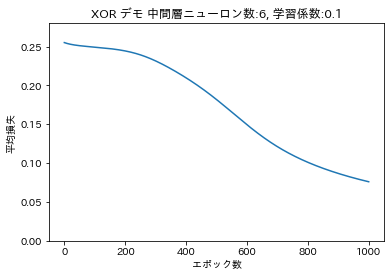

In [5]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Tch = np.array([[0],[1],[1],[0]])

n_hid = 6
lr = 1e-1

#LayerH = layer(n_out=n_hid, n_inp=2, act_f=sigmoid, lr=lr)
#LayerH = layer(n_out=n_hid, n_inp=2, act_f=ReLU, lr=lr)
LayerH = layer(n_out=n_hid, n_inp=2, act_f=tanh, lr=lr)
LayerO = layer(n_out=1, n_inp=n_hid, act_f=sigmoid, lr=lr)

epochs = 10 ** 3
interval = epochs >> 2
losses = []
for epoch in range(epochs+1):
    H = LayerH.forward(X)
    O = LayerO.forward(H)

    deltaO = O - Tch
    deltaH, dWo = LayerO.backward(deltaO, O, H)
    deltaX, dWh = LayerH.backward(deltaH, H, X)
    LayerO.update(dWo)
    LayerH.update(dWh)

    losses.append((deltaO ** 2).mean())
    if epoch % interval == 0:
        print(f'エポック:{epoch:>5d}, 損失値: {losses[-1]:.3f}', end=" ")
        print(f'出力:{O.T}')

plt.ylim((0,0.28))
plt.plot(losses)
plt.xlabel('エポック数')
plt.ylabel('平均損失')
plt.title(f'XOR デモ 中間層ニューロン数:{n_hid}, 学習係数:{lr}')
plt.show()

In [6]:
class XOR_demo():
    def __init__(self, n_hid=8, lr=1e-1, act_f=tanh, max_epochs= 3 * 10 ** 3, interval=(10 ** 3)>>3):
        
        if act_f != None:
            self.act_f = act_f
            
        self.X = np.array([[0,0],[0,1],[1,0],[1,1]])
        self.Tch = np.array([[0],[1],[1],[0]])
        
        self.max_epochs = max_epochs
        self.interval = interval
        self.n_hid = n_hid
        self.lr = lr

        self.LayerH = layer(n_out=n_hid, n_inp=2, act_f=self.act_f, lr=lr)
        self.LayerO = layer(n_out=1, n_inp=n_hid, act_f=sigmoid, lr=lr)


    def fit(self, max_epochs=None, interval=None, draw_graph=True, title="", verbose=False):
        if max_epochs != None:
            self.max_epochs = max_epochs
        if interval != None:
            self.interval = interval
            
        losses = []
        for epoch in range(self.max_epochs+1):
            #順伝播
            H = self.LayerH.forward(X)
            O = self.LayerO.forward(H)

            #逆伝播
            deltaO = (O - Tch) 
            deltaH, dWo = self.LayerO.backward(deltaO, O, H)
            deltaX, dWh = self.LayerH.backward(deltaH, H, X)
            
            #パラメータの更新
            self.LayerO.update(dWo)
            self.LayerH.update(dWh)

            losses.append((deltaO ** 2).mean())
            if epoch % self.interval == 0 and verbose:
                print(f'エポック:{epoch:>5d}, 損失: {losses[-1]:.3f}', end=" ")
                print(f'出力:{O.T}')

        if draw_graph:
            plt.ylim((0,0.28))
            plt.plot(losses)
            plt.xlabel('エポック数')
            plt.ylabel('平均損失')
            plt.title(title) # f'XOR デモ 中間層ニューロン数:{n_hid}, 学習係数:{lr}')
            plt.show()

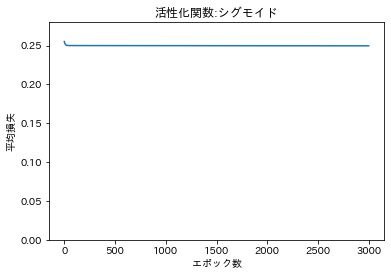

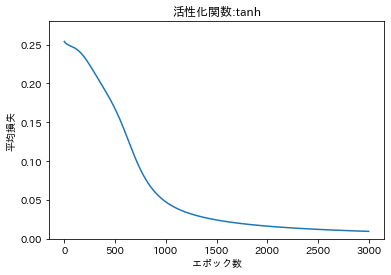

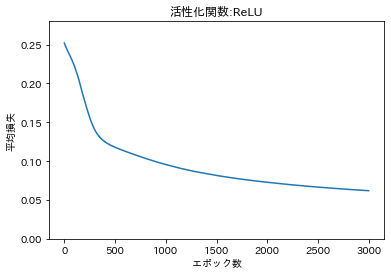

In [7]:
demo = XOR_demo(act_f=sigmoid)
demo.fit(title="活性化関数:シグモイド")

demo2 = XOR_demo(act_f=tanh)
demo2.fit(title="活性化関数:tanh")

demo3 = XOR_demo(act_f=ReLU, )
demo3.fit(title="活性化関数:ReLU")

# SGD と ADAM の比較

<!-- - source: https://github.com/jrios6/Adam-vs-SGD-Numpy.git-->
<!--This is a response to Siraj Raval's [Coding Challenge](https://github.com/llSourcell/The_evolution_of_gradient_descent/) to implement the Adam Optimization Strategy. 
ta), and comparing the performance difference between a standard Stochastic Gradient Descent and Adam.
-->

参照 URL
1. [Adam: A method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) by Diederik P. Kingma, Jimmy Ba  
2. [CS231: Neural Networks](http://cs231n.github.io/neural-networks-3/#update) by Andrej Karpathy
3. [Optimizing Gradient Descent](http://sebastianruder.com/optimizing-gradient-descent/index.html#adam) by Sebastian Ruder

## 以前と同様のデータセットを準備

In [8]:
import numpy as np
import sys
import requests

mnist_urls = {
    #http://yann.lecun.com/exdb/mnist/
    'Xtrain': 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'Ytrain': 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
    'Xtest': 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    'Ytest':'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
}

fashionmnist_urls = {
    #https://github.com/zalandoresearch/fashion-mnist
    'Xtest': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
    'Ytest': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
    'Xtrain': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
    'Ytrain': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'
}

kmnist_urls = {
    #http://codh.rois.ac.jp/kmnist/
    'Xtrain': 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
    'Ytrain': 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
    'Xtest': 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
    'Ytest': 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'
}
 

def download_mnist(dataset):
    #上で定義したデータセットの情報を元にデータをダウンロードする
    for name, url in dataset.items():
        fname = url.split('/')[-1]
        print(url, fname)
        r = requests.get(url, timeout=35) #timeout=None はサーバからの応答が遅い場合永遠に待ち続ける
        with open(fname, 'wb') as f:
            f.write(r.content)

#データを変更して，繰り返し実行する際には，次行行頭の # を削除して，上のセルを再実行する必要があります
# !rm *.gz
# !ls -l *.gz*

mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fashionmnist_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat' , \
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
kmnist_labels = ['お', 'き', 'す', 'つ', 'な', 'は', 'ま', 'や', 'れ', 'を']
# '0,U+304A,お', '1,U+304D,き', '2,U+3059,す', '3,U+3064,つ', '4,U+306A,な', 
# '5,U+306F,は', '6,U+307E,ま', '7,U+3084,や', '8,U+308C,れ', '9,U+3092,を'

labels = mnist_labels
labels = fashionmnist_labels
labels = kmnist_labels

#以下の 3 つのデータセットのうち 1 つを選んで実習してみましょう
dataset = mnist_urls
#dataset = fashionmnist_urls
dataset = kmnist_urls

labels = mnist_labels
#labels = fashionmnist_labels
labels = kmnist_labels

download_mnist(dataset)

http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz train-images-idx3-ubyte.gz
http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz train-labels-idx1-ubyte.gz
http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz t10k-images-idx3-ubyte.gz
http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz t10k-labels-idx1-ubyte.gz


In [9]:
def load_mnist(path, kind='train'):
    """ダウンロードしたデータを読み込む関数"""
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

次行の数字を変更して実施してください。ただし数字の範囲は 0 から 59999 までです:33


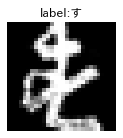

In [10]:
#データの表示
import matplotlib.pyplot as plt
X_train, Y_train = load_mnist('.', kind='train')
X_test, Y_test = load_mnist('.', kind='t10k')

_Y = np.zeros((len(Y_train),10))
for i in range(len(_Y)):
    _Y[i,Y_train[i]] = 1
Y_train = _Y

_Y = np.zeros((len(Y_test),10))
for i in range(len(_Y)):
    _Y[i,Y_test[i]] = 1
Y_test = _Y

# 時間節約のためデータ数を制限
n_train = 3000  # 訓練データ数
n_val = 500     # 検証データ数
n_test = 500    # テストデータ数
X_train = X_train[-n_train:]
Y_train = Y_train[-n_train:]
X_val = X_train[-n_val:]
Y_val = Y_train[-n_val:]
X_test = X_test[-n_test:]
Y_test = Y_test[-n_test:]

#次行の数字を変更して実施してください。ただし数字の範囲は 0 から 59999 までです
No = int(input('次行の数字を変更して実施してください。ただし数字の範囲は 0 から 59999 までです:'))
#No = 666
plt.figure(figsize=(2,2))    #表示する縦横の大きさ，単位はインチ
plt.title('label:{}'.format(labels[np.argmax(Y_train[No])]))
plt.axis(False)
plt.imshow(X_train[No].reshape(28,28), cmap='gray')
plt.show()

## 3 層ニューラルネットワーク MLP の定義

In [11]:
class MLP3:
    def __init__(self, n_inp, n_hid, n_out, lr, act_f=tanh):
        
        if act_f == None:
            act_f = tanh

        self.n_inp = n_inp  # 入力層 ニューロン(特徴）数
        self.n_hid = n_hid  # 中間層 ニューロン数
        self.n_out = n_out  # 出力層 ニューロン数
        self.act_f = act_f  # 活性化関数
        self.lr = lr        # 学習率
        self.V_m, self.U_m = 0, 0  # 1 次のモーメント, 慣性モーメント
        self.V_v, self.U_v = 0, 0  # 2 次のモーメント, 速度ベロシティのモーメンタム 
        self.t = 0
        
        # 結合係数行列の初期化
        self.U = np.random.randn((n_inp * n_hid)).reshape(n_inp, n_hid) / np.sqrt(n_inp + n_hid)
        self.V = np.random.randn((n_hid * n_out)).reshape(n_hid, n_out) / np.sqrt(n_hid + n_out)


    def train(self, X, Tch, optimizer, decay1 = None, decay2 = None, epsilon = 1e-7):
        # 順伝播
        H = self.act_f(X @ self.U)
        Y = self.act_f(H @ self.V)
        
        # 誤差逆伝播
        Y_delta = Y - Tch
        Y_grad  = Y_delta * self.act_f(Y, back=True)
        H_delta = Y_grad @ self.V.T
        H_grad  = H_delta * self.act_f(H, back=True)
        
        if optimizer == 'sgd':
            # Update Weights
            self.V -= self.lr * H.T @ Y_grad
            self.U -= self.lr * X.T @ H_grad
            
        if optimizer == 'adam':
            # Gradients for each layer
            g1 = H.T.dot(Y_grad)
            g0 = X.T.dot(H_grad)
            
            self.t += 1         # 時刻の更新
            
            # 中間層と出力層とに対する慣性モーメントを計算
            self.V_m = self.V_m * decay1 + (1 - decay1) * g1
            self.U_m = self.U_m * decay1 + (1 - decay1) * g0
            
            # 中間層と出力層とに対する 2 次モーメントを計算
            self.V_v = self.V_v * decay2 + (1 - decay2) * (g1 ** 2)
            self.U_v = self.U_v * decay2 + (1 - decay2) * (g0 ** 2)
            
            # 出力層モーメントへの時刻補正
            V_mc = self.V_m / (1 - (decay1 ** self.t))
            V_vc = self.V_v / (1 - (decay2 ** self.t))
            
            # 入力層モーメントへの時刻補正
            U_mc = self.U_m / (1 - (decay1 ** self.t))
            U_vc = self.U_v / (1 - (decay2 ** self.t))
            
            # パラメータ更新
            dV = V_mc / (np.sqrt(V_vc) + epsilon)
            dU = U_mc / (np.sqrt(U_vc) + epsilon)
            
            self.V -= self.lr * dV
            self.U -= self.lr * dU
            
    def run(self, X):
        H = self.act_f(X @ self.U)
        Y = self.act_f(H @ self.V)
        
        return Y


In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [13]:
import time
import sys

def build_and_run(network, epochs=100, optimizer='adam', n_batch=64):
    losses = {'train':[], 'validation':[]} # For Plotting of MSE
    start = time.time()
    interval = epochs >> 3
    
    # Iterating Over Epochs
    for i in range(epochs):
        
        if optimizer == 'sgd':
            # Iterating over mini batches
            for k in range(X_train.shape[0] // n_batch):
                batch = np.random.choice(len(X_train), size=n_batch)
                X, y = X_train[batch], Y_train[batch]
                network.train(X, y, optimizer)
                train_loss = MSE(network.run(X_train), Y_train)
                val_loss = MSE(network.run(X_val), Y_val)
            if i % interval == 0:
                print(f'エポック数:{i:05d}, 訓練損失:{train_loss:0.3f}, 検証損失: {val_loss:0.3f}')
                
        if optimizer == 'adam':
            # Iterating over mini batches
            for k in range(X_train.shape[0]// n_batch):
                batch = np.random.choice(len(X_train), size=n_batch)
                X, y = X_train[batch], Y_train[batch]
                #print(f'30 X.shape: {X.shape}, y.shape: {y.shape}')
                network.train(X, y, optimizer,
                              decay1 = 0.9, decay2 = 0.99,
                              epsilon = 10e-8)
                train_loss = MSE(network.run(X_train), Y_train)
                val_loss = MSE(network.run(X_val), Y_val)
            if i % interval == 0:
                print(f'エポック数:{i:05d}, 訓練損失:{train_loss:0.3f}, 検証損失: {val_loss:0.3f}')

        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
    print(f'総計算時間:{time.time()-start:.4f} 秒')
    return losses

In [14]:
epochs = 101
lr = 1e-4
n_hid = 128

n_out = 10
batch_size = 128

act_f = tanh
print('活性化関数:tanh 最適化手法:Adam')
model_tanh_adam = MLP3(X_train.shape[1], n_hid, n_out, lr, act_f=act_f)
losses_adam_tanh = build_and_run(model_tanh_adam, epochs, 'adam', batch_size)

print('活性化関数:tanh 最適化手法:SGD')
model_tanh_sgd = MLP3(X_train.shape[1], n_hid, n_out, lr, act_f=act_f)
losses_sgd_tanh = build_and_run(model_tanh_sgd, epochs, 'sgd', batch_size)

act_f = sigmoid
print('活性化関数:シグモイド 最適化手法:Adam')
model_sigmoid_adam = MLP3(X_train.shape[1], n_hid, n_out, lr, act_f=act_f)
losses_adam_sigmoid = build_and_run(model_sigmoid_adam, epochs, 'adam', batch_size)

print('活性化関数:シグモイド 最適化手法:SGD')
model_sigmoid_sgd = MLP3(X_train.shape[1], n_hid, n_out, lr, act_f=act_f)
losses_sgd_sigmoid = build_and_run(model_sigmoid_sgd, epochs, 'sgd', batch_size)

活性化関数:tanh 最適化手法:Adam
エポック数:00000, 訓練損失:0.352, 検証損失: 0.361
エポック数:00012, 訓練損失:0.184, 検証損失: 0.190
エポック数:00024, 訓練損失:0.128, 検証損失: 0.135
エポック数:00036, 訓練損失:0.097, 検証損失: 0.102
エポック数:00048, 訓練損失:0.077, 検証損失: 0.081
エポック数:00060, 訓練損失:0.065, 検証損失: 0.068
エポック数:00072, 訓練損失:0.057, 検証損失: 0.059
エポック数:00084, 訓練損失:0.050, 検証損失: 0.052
エポック数:00096, 訓練損失:0.046, 検証損失: 0.048
総計算時間:103.0691 秒
活性化関数:tanh 最適化手法:SGD
エポック数:00000, 訓練損失:0.233, 検証損失: 0.226
エポック数:00012, 訓練損失:0.069, 検証損失: 0.067
エポック数:00024, 訓練損失:0.055, 検証損失: 0.054
エポック数:00036, 訓練損失:0.048, 検証損失: 0.047
エポック数:00048, 訓練損失:0.044, 検証損失: 0.043
エポック数:00060, 訓練損失:0.042, 検証損失: 0.041
エポック数:00072, 訓練損失:0.039, 検証損失: 0.038
エポック数:00084, 訓練損失:0.038, 検証損失: 0.038
エポック数:00096, 訓練損失:0.036, 検証損失: 0.036
総計算時間:89.6438 秒
活性化関数:シグモイド 最適化手法:Adam
エポック数:00000, 訓練損失:0.188, 検証損失: 0.187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


エポック数:00012, 訓練損失:0.080, 検証損失: 0.080
エポック数:00024, 訓練損失:0.065, 検証損失: 0.065
エポック数:00036, 訓練損失:0.053, 検証損失: 0.053
エポック数:00048, 訓練損失:0.044, 検証損失: 0.044
エポック数:00060, 訓練損失:0.037, 検証損失: 0.037
エポック数:00072, 訓練損失:0.032, 検証損失: 0.032
エポック数:00084, 訓練損失:0.029, 検証損失: 0.029
エポック数:00096, 訓練損失:0.026, 検証損失: 0.026
総計算時間:117.9581 秒
活性化関数:シグモイド 最適化手法:SGD
エポック数:00000, 訓練損失:0.116, 検証損失: 0.116
エポック数:00012, 訓練損失:0.077, 検証損失: 0.077
エポック数:00024, 訓練損失:0.069, 検証損失: 0.069
エポック数:00036, 訓練損失:0.063, 検証損失: 0.063
エポック数:00048, 訓練損失:0.058, 検証損失: 0.058
エポック数:00060, 訓練損失:0.054, 検証損失: 0.054
エポック数:00072, 訓練損失:0.052, 検証損失: 0.051
エポック数:00084, 訓練損失:0.049, 検証損失: 0.049
エポック数:00096, 訓練損失:0.047, 検証損失: 0.047
総計算時間:112.0264 秒


In [ ]:
plt.plot(losses_adam_tanh['train'], label='Adam(tanh) 訓練データ損失')
plt.plot(losses_adam_tanh['validation'], label='Adam(tahn) 検証データ損失')

plt.plot(losses_sgd_tanh['train'], label='SGD(tanh) 訓練データ損失')
plt.plot(losses_sgd_tanh['validation'], label='SGD(tanh) 検証データ損失')
plt.legend()

<!--
From the plots, we can observed that using Adam, weights of the neural network are more smoothly adjusted to reduce the training loss. 
Try increasing the learning rate, and you can see that Adam converges much faster compared to SGD, using an adaptive learning rate.

The benefits of using Adam are not so obvious as the size of the data is very small and increasing training epochs tend to lead to overfitting and early-stopping is required. 
It is recommended to set the epochs for Adam to around 200 for the above hyperparameters configuration, as the training and validation loss starts diverging. 
However, we kept the epochs for both networks the same for plotting.

Lastly, in this implementation, Adam is much faster to compute compared to SGD as it is processed as an entire training batch.  
-->

## テストデータ による検証

In [ ]:
def test_model(network):
    test_predictions = network.run(X_test)
    correct = 0
    total = 0
    for i in range(len(test_predictions)):
        total += 1
        if np.argmax(test_predictions[i]) ==  np.argmax(Y_test[i]):
            correct += 1
    return correct/total
    

In [ ]:
print('テストデータセットに対する精度')
print(f'Adam (シグモイド) : {test_model(model_sigmoid_adam)}')
print(f'SGD  (シグモイド) : {test_model(model_sigmoid_sgd)}')
print(f'Adam (tahn)     : {test_model(model_sigmoid_adam)}')
print(f'SGD  (tanh)     : {test_model(model_sigmoid_sgd)}')

In [2]:
#from sklearn.utils.fixes import signature
!pip install install funcsigs
from funcsigs import signature 